# Analysis of time performance of the soundness verification algorithm for Data Petri Nets

During the generation of DPNs, the following parameters have been taken as an input:

- PlacesCount - number of places in the DPN.
- TransitionsCount - number of transitions in the DPN.
- ArcsCount - number of arcs in the DPN (but actually number of arcs was predetermined by a number of transitions and places but it was possible to configure a number of additional arcs that are added when the backbone of the DPN is constructed)
- VarsCount - number of variables.
- ConditionsCount - number of atomic conditions in the DPN. Each transition may have 0, 1 or n conditions. In case of n conditions, they can be combined through conjunction and disjunction (logical connective is chosen randomly, but the result expression must conform to DNF).

As a result, the constraint graph (or its fragment) is constructed. The constraint graph has the following properties:

- ConstraintStates - number of states in the constraint graph for the DPN.
- ConstraintArcs - number of arcs in the constraint graph for the DPN.
- Boundedness - is the whole constraint graph constructed (if the whole, then the net is guaranteed to be bounded).

Then, constraint graph is analyzed using graph traversing techniques, and the following properties are obtained:

- DeadTransitions - number of dead transitions in the DPN.
- Deadlocks - existence of deadlocks in the DPN.
- Soundness - whether the DPN data-aware sound or not.

Finally, the program measures time needed for checking a DPN for soundness:

- Milliseconds - number of milliseconds needed for the algorithm to terminate with an answer regarding data-aware soundness of the DPN.

In [1]:
import math
import statistics

import numpy as np
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from scipy import stats
from scipy.stats import norm

import statsmodels.api as sm

## QE-based Implementation

### Read dataset for generated DPNs and results of their verification

In [2]:
df = pd.read_csv('results_qeIml_total.csv')

In [3]:
df

,PlacesCount,TransitionsCount,ArcsCount,VarsCount,ConditionsCount,Boundedness,ConstraintStates,ConstraintArcs,DeadTransitions,Deadlocks,Soundness,Milliseconds
0,2,1,2,1,0,True,2,1,0,False,True,32
1,2,1,2,1,0,True,2,1,0,False,True,1
2,2,1,2,1,0,True,2,1,0,False,True,1
3,2,1,2,1,0,True,2,1,0,False,True,1
4,2,1,2,1,0,True,2,1,0,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...
36251,255,255,688,140,155,False,70,69,232,False,False,931
36252,255,255,690,140,155,False,2969,2968,167,False,False,63913
36253,255,255,690,140,155,False,2678,2678,154,False,False,30660
36254,255,255,690,140,155,False,554,553,199,False,False,4618


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36256 entries, 0 to 36255
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   PlacesCount       36256 non-null  int64
 1   TransitionsCount  36256 non-null  int64
 2   ArcsCount         36256 non-null  int64
 3   VarsCount         36256 non-null  int64
 4   ConditionsCount   36256 non-null  int64
 5   Boundedness       36256 non-null  bool 
 6   ConstraintStates  36256 non-null  int64
 7   ConstraintArcs    36256 non-null  int64
 8   DeadTransitions   36256 non-null  int64
 9   Deadlocks         36256 non-null  bool 
 10  Soundness         36256 non-null  bool 
 11  Milliseconds      36256 non-null  int64
dtypes: bool(3), int64(9)
memory usage: 2.6 MB


### Filtering
If the model has a high amount of dead transitions, the soundness verification algorithm may terminate very quickly, even at first states. In the case of a high amount of dead transitions, the size of the model as well as quantity of variables barely influence time needed for the algorithm: it will mostly require less then hundreds of milliseconds to terminate. In addition, real business process models, in general, have quite low quantity of dead transitions. Thus, it is better to filter the source dataset by the portion of dead transitions. Since it is very difficult to get a huge model with a very low amount of dead transitions, it was decided to consider models with less than 60% of dead transitions.

Taking only cases with less than 60% of dead transitions:

In [5]:
df_filtered = df[df.DeadTransitions < 0.6 * df.TransitionsCount]

In [6]:
df_filtered

,PlacesCount,TransitionsCount,ArcsCount,VarsCount,ConditionsCount,Boundedness,ConstraintStates,ConstraintArcs,DeadTransitions,Deadlocks,Soundness,Milliseconds
0,2,1,2,1,0,True,2,1,0,False,True,32
1,2,1,2,1,0,True,2,1,0,False,True,1
2,2,1,2,1,0,True,2,1,0,False,True,1
3,2,1,2,1,0,True,2,1,0,False,True,1
4,2,1,2,1,0,True,2,1,0,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...
36040,240,240,645,230,125,False,3926,3925,141,False,False,105239
36063,240,240,644,260,125,False,2664,2706,139,False,False,291277
36215,255,255,690,215,140,False,5467,5466,148,False,False,151723
36225,255,255,689,230,140,False,9114,9113,138,False,False,599575


### Comparing value of each input parameter (PlacesCount, TransitionsCount, ArcsCount, VarsCount and ConditionsCount) with Milliseconds needed for the algorithm to terminate

#### Number of places

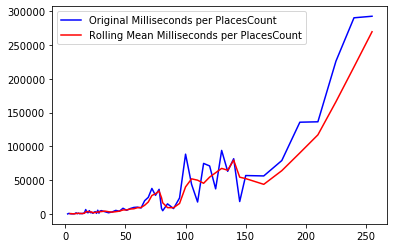

In [7]:
ms_per_places = df_filtered.groupby('PlacesCount').mean()['Milliseconds']
plt.plot(ms_per_places, color="blue",label="Original Milliseconds per PlacesCount") 
rolling_mean = ms_per_places.rolling(3).mean() 
plt.plot(rolling_mean, color="red", label="Rolling Mean Milliseconds per PlacesCount") 
plt.legend(loc="best")

#### Number of transitions

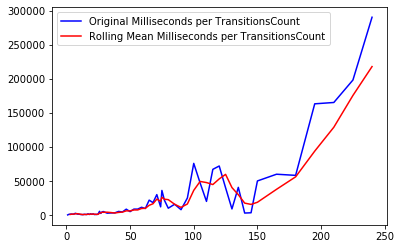

In [8]:
ms_per_transitions = df_filtered[df_filtered.TransitionsCount <= 250].groupby('TransitionsCount').mean()['Milliseconds']
plt.plot(ms_per_transitions, color="blue",label="Original Milliseconds per TransitionsCount") 
rolling_mean = ms_per_transitions.rolling(3).mean() 
plt.plot(rolling_mean, color="red", label="Rolling Mean Milliseconds per TransitionsCount") 
plt.legend(loc="best")

#### Number of arcs

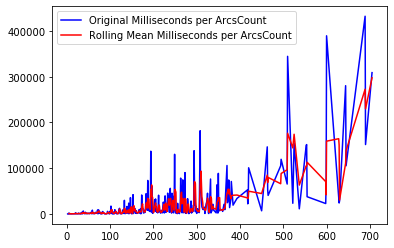

In [9]:
ms_per_arcs = df_filtered.groupby('ArcsCount').mean()['Milliseconds']
plt.plot(ms_per_arcs, color="blue",label="Original Milliseconds per ArcsCount") 
rolling_mean = ms_per_arcs.rolling(3).mean() 
plt.plot(rolling_mean, color="red", label="Rolling Mean Milliseconds per ArcsCount") 
plt.legend(loc="best")

#### Number of variables

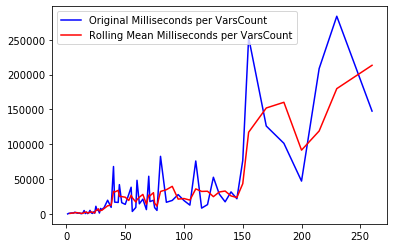

In [10]:
ms_per_vars = df_filtered.groupby('VarsCount').mean()['Milliseconds']
plt.plot(ms_per_vars, color="blue",label="Original Milliseconds per VarsCount") 
rolling_mean = ms_per_vars.rolling(3).mean() 
plt.plot(rolling_mean, color="red", label="Rolling Mean Milliseconds per VarsCount") 
plt.legend(loc="best")

#### Number of conditions

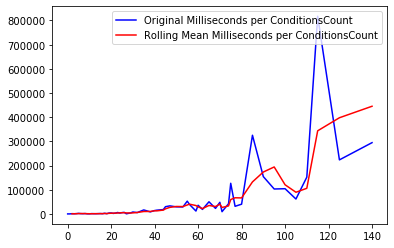

In [11]:
ms_per_conditions = df_filtered.groupby('ConditionsCount').mean()['Milliseconds']
plt.plot(ms_per_conditions, color="blue",label="Original Milliseconds per ConditionsCount") 
rolling_mean = ms_per_conditions.rolling(3).mean() 
plt.plot(rolling_mean, color="red", label="Rolling Mean Milliseconds per ConditionsCount") 
plt.legend(loc="best")

## Dataset description

In [12]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8526 entries, 0 to 36236
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   PlacesCount       8526 non-null   int64
 1   TransitionsCount  8526 non-null   int64
 2   ArcsCount         8526 non-null   int64
 3   VarsCount         8526 non-null   int64
 4   ConditionsCount   8526 non-null   int64
 5   Boundedness       8526 non-null   bool 
 6   ConstraintStates  8526 non-null   int64
 7   ConstraintArcs    8526 non-null   int64
 8   DeadTransitions   8526 non-null   int64
 9   Deadlocks         8526 non-null   bool 
 10  Soundness         8526 non-null   bool 
 11  Milliseconds      8526 non-null   int64
dtypes: bool(3), int64(9)
memory usage: 691.1 KB


#### Number of places

C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Admin\Miniconda3\envs\IntroML\l

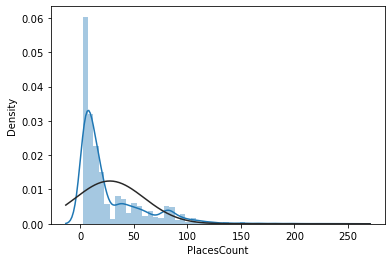

In [13]:
sns.distplot(df_filtered.PlacesCount, fit=stats.norm)

#### Number of transitions

C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Admin\Miniconda3\envs\IntroML\l

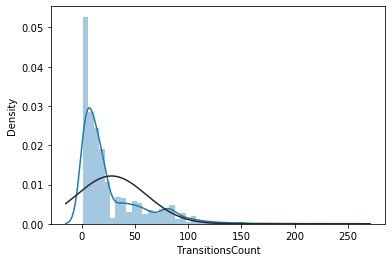

In [14]:
sns.distplot(df_filtered.TransitionsCount, fit=stats.norm)

#### Number of arcs

C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Admin\Miniconda3\envs\IntroML\l

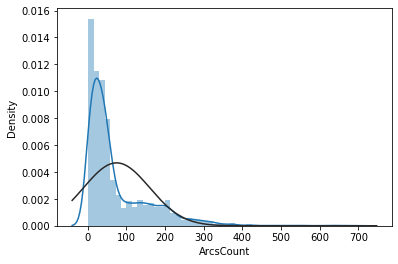

In [15]:
sns.distplot(df_filtered.ArcsCount, fit=stats.norm)

#### Number of variables

C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Admin\Miniconda3\envs\IntroML\l

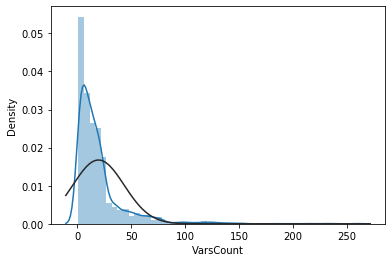

In [16]:
sns.distplot(df_filtered.VarsCount, fit=stats.norm)

#### Number of conditions

C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Admin\Miniconda3\envs\IntroML\l

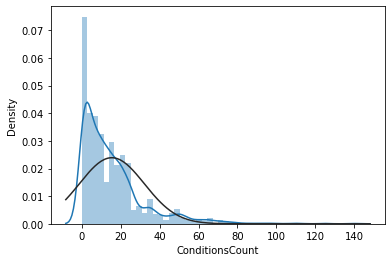

In [17]:
sns.distplot(df_filtered.ConditionsCount, fit=stats.norm)

According to visualizations, all input parameters have a highly skewed leptokurtic distribution with positive skewness. It can be explained by the following factors:

- Actually, with the growth of the size of the model, the step to increase the models has also grown. Specifically, the step for values of parameters in range from 1 to 25 was 1, for values in range from 25 to 75 the step was 3, for values from 75 to 125 the range was 5, etc.
- The portion of DPNs with dead transitions < 50% of the all transitions, generally, decreases with the size of the model.

#### Milliseconds needed for the algorithm

C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Admin\Miniconda3\envs\IntroML\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Admin\Miniconda3\envs\IntroML\l

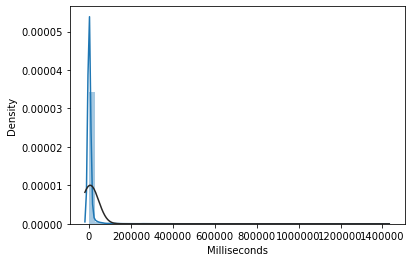

In [18]:
sns.distplot(df_filtered.Milliseconds, fit=stats.norm)

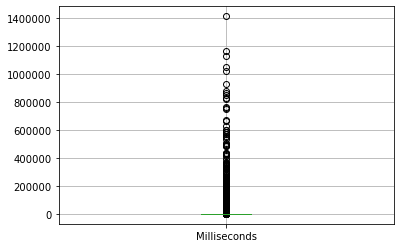

In [19]:
df.boxplot(['Milliseconds'])

The plot shows that there are outliers in time needed for the algorithm, and mostly the algorithm requires quite small amount of time to check for soundness (potentially, it is due to the fact that there are more cases for 1..25 places/transitions/extra arcs/variables/conditions that influence the distribution of this variable).

### Potentially, we can make a more equal distribution!!!

### Correlations between variables in the dataset:

In [40]:
df_filtered[['PlacesCount', 'TransitionsCount', 'ArcsCount', 'VarsCount', 'ConditionsCount']].corr('spearman')

,PlacesCount,TransitionsCount,ArcsCount,VarsCount,ConditionsCount
PlacesCount,1.000000,0.873686,0.947608,0.804812,0.820873
TransitionsCount,0.873686,1.000000,0.968622,0.757317,0.775747
ArcsCount,0.947608,0.968622,1.000000,0.758479,0.779709
VarsCount,0.804812,0.757317,0.758479,1.000000,0.748286
ConditionsCount,0.820873,0.775747,0.779709,0.748286,1.000000


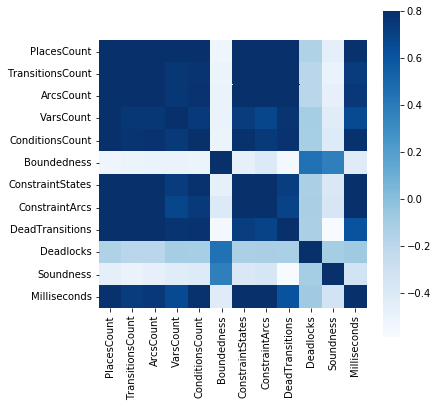

In [20]:
corr = df_filtered.corr('spearman')
plt.figure(figsize=(6, 6))
sns.heatmap(corr, vmax=.8, square=True, cmap='Blues')
plt.show()

It is seen that there is quite high correlation between input parameters and actual time needed for the algorithm to terminate

In [21]:
df_filtered.corrwith(df['Milliseconds'],  method='spearman').sort_values(ascending=False)

Milliseconds        1.000000
ConstraintStates    0.901768
ConstraintArcs      0.899372
ConditionsCount     0.788798
PlacesCount         0.785155
ArcsCount           0.755215
TransitionsCount    0.729949
VarsCount           0.659992
DeadTransitions     0.619051
Deadlocks          -0.069714
Soundness          -0.327116
Boundedness        -0.423366
dtype: float64

### Model for all parameters

Using linear regression to evaluate influence of any parameters on the time needed for the algorithm to terminate. From the correlation table above, we can conclude that the relation between constraint states, constraint arcs and milliseconds is almost linear; thus, we can try to use linear regression model:

In [22]:
x_mult = df_filtered[['PlacesCount', 'TransitionsCount', 'ArcsCount', 'VarsCount', 'ConditionsCount',
                       'Boundedness', 'ConstraintStates', 'ConstraintArcs', 'DeadTransitions', 'Deadlocks', 'Soundness']]
y = df_filtered['Milliseconds']
x_mult_constant = sm.add_constant(x_mult)

In [23]:
model = sm.OLS(y, x_mult_constant.astype(float)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Milliseconds   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     339.9
Date:                Fri, 15 Jul 2022   Prob (F-statistic):               0.00
Time:                        10:46:56   Log-Likelihood:            -1.0084e+05
No. Observations:                8526   AIC:                         2.017e+05
Df Residuals:                    8514   BIC:                         2.018e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -4957.2375    734.847  

In [24]:
print('R^2 = {:f}'.format(model.rsquared))
print('F-test significance = {:f}'.format(model.f_pvalue))

R^2 = 0.305159
F-test significance = 0.000000


In [25]:
f'Statistically significant model parameters: {model.pvalues[model.pvalues < 0.05].index.values}'

"Statistically significant model parameters: ['const' 'PlacesCount' 'TransitionsCount' 'ArcsCount' 'VarsCount'\n 'ConditionsCount' 'Boundedness' 'ConstraintStates' 'ConstraintArcs'\n 'DeadTransitions']"

It is seen that ConditionsCount has the highest influence on the model: increase in conditionsCount by 1, on average, increases time needed for the algorithm to terminate by 0.438 seconds

### Model for input parameters
Here we cannot straightforwardly use a linear regression model since milliseconds grow exponentially with the increase of most input parameters. Thus, we can take log from milliseconds and use the linear regression model with the dependent variable log(milliseconds).

(Based on correlation matrix, we can conclude that placesCount and transitionsCount highly correlate with each other; thus, we can choose one of them to represent the size of the model. Let us choose PlacesCount)

In [26]:
df_filtered['log_milliseconds'] = df_filtered.apply(lambda x: math.log(x['Milliseconds']+1), axis = 1)

<ipython-input-26-5898ef7834df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['log_milliseconds'] = df_filtered.apply(lambda x: math.log(x['Milliseconds']+1), axis = 1)


In [27]:
x_mult2 = df_filtered[['PlacesCount', 'TransitionsCount', 'ArcsCount', 'VarsCount', 'ConditionsCount']]#, 
y2 = df_filtered['log_milliseconds']
x_mult_constant2 = sm.add_constant(x_mult2)

In [28]:
model2 = sm.OLS(y2, x_mult_constant2.astype(float)).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:       log_milliseconds   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     2600.
Date:                Fri, 15 Jul 2022   Prob (F-statistic):               0.00
Time:                        10:46:57   Log-Likelihood:                -16003.
No. Observations:                8526   AIC:                         3.202e+04
Df Residuals:                    8520   BIC:                         3.206e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.4578      0.025  

In [29]:
coefs = pd.DataFrame()
coefs['Coefs'] = model2.params[1:]
coefs['Coefs'] = (np.exp(coefs['Coefs']) - 1) * 100
coefs['Features'] = model2.params.index[1:]
coefs.set_index('Features', inplace=True)
coefs

,Coefs
Features,
PlacesCount,4.448996
TransitionsCount,-2.129341
ArcsCount,0.152752
VarsCount,0.770934
ConditionsCount,6.579329


#### Trying to use linear model against net_size = |Places| * |Transitions|

In [30]:
df_filtered['net_size'] = df_filtered.PlacesCount * df_filtered.TransitionsCount

<ipython-input-30-06e3bc7f2c1a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['net_size'] = df_filtered.PlacesCount * df_filtered.TransitionsCount


In [31]:
x_mult2 = df_filtered[['net_size', 'ArcsCount', 'VarsCount', 'ConditionsCount']]
y2 = df_filtered['log_milliseconds']
x_mult_constant2 = sm.add_constant(x_mult2)

In [32]:
model2 = sm.OLS(y2, x_mult_constant2.astype(float)).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:       log_milliseconds   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     3762.
Date:                Fri, 15 Jul 2022   Prob (F-statistic):               0.00
Time:                        10:46:57   Log-Likelihood:                -15615.
No. Observations:                8526   AIC:                         3.124e+04
Df Residuals:                    8521   BIC:                         3.128e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.9498      0.027    1

In [33]:
coefs = pd.DataFrame()
coefs['Coefs'] = model2.params[1:]
coefs['Coefs'] = (np.exp(coefs['Coefs']) - 1) * 100
coefs['Features'] = model2.params.index[1:]
coefs.set_index('Features', inplace=True)
coefs

,Coefs
Features,
net_size,-0.026641
ArcsCount,1.890156
VarsCount,1.712771
ConditionsCount,7.310468


### Protocol №2

Consider only DPNs with the following setup:

- 1.2n places,
- n transitions
- 0.5n additional arcs
- 0.5n variables
- n conditions.

n is a natural number varying from 5 to 115 with a step equal to 5.

For each configuration, 3 DPNs are generated and tested. All nets are with Dead Transitions < 0.6 * Transitions

In [34]:
df1 = pd.read_csv('results_qeIml_protocol_2.csv')
df1

,PlacesCount,TransitionsCount,ArcsCount,VarsCount,ConditionsCount,Boundedness,ConstraintStates,ConstraintArcs,DeadTransitions,Deadlocks,Soundness,Milliseconds
0,6,5,12,3,5,False,7,6,2,False,False,33
1,6,5,13,3,5,False,7,6,1,False,False,133
2,6,5,12,3,5,False,6,5,2,False,False,40
3,12,10,26,5,10,False,12,11,4,False,False,64
4,12,10,27,5,10,False,25,24,0,False,True,130
...,...,...,...,...,...,...,...,...,...,...,...,...
66,132,110,315,55,110,False,2453,2478,65,False,False,267205
67,132,110,317,55,110,False,1223,1222,60,False,False,40078
68,138,115,331,57,115,False,2561,3698,50,False,False,446321
69,138,115,330,57,115,False,1692,1696,59,False,False,370028


### Time needed for the algorithm with the growth of n

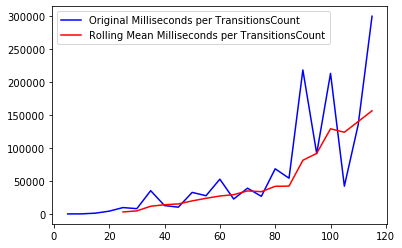

In [35]:
ms_per_places = df1.groupby('TransitionsCount').mean()['Milliseconds']
plt.plot(ms_per_places, color="blue",label="Original Milliseconds per TransitionsCount") 
rolling_mean = ms_per_places.rolling(5).mean() 
plt.plot(rolling_mean, color="red", label="Rolling Mean Milliseconds per TransitionsCount") 
plt.legend(loc="best")

## Own implementation

### Protocol 2

Consider only DPNs with the following setup:

- 1.2n places,
- n transitions
- 0.5n additional arcs
- 0.5n variables
- n conditions.

n is a natural number varying from 5 to 115 with a step equal to 5.

For each configuration, 3 DPNs are generated and tested. All nets are with Dead Transitions < 0.6 * Transitions

In [37]:
df2 = pd.read_csv('results_myImpl_protocol_2.csv')
df2

,PlacesCount,TransitionsCount,ArcsCount,VarsCount,ConditionsCount,Boundedness,ConstraintStates,ConstraintArcs,DeadTransitions,Deadlocks,Soundness,Milliseconds
0,6,5,13,3,5,False,8,7,0,False,True,85
1,6,5,12,3,5,True,6,6,2,True,False,29
2,6,5,12,3,5,False,8,8,1,False,False,47
3,12,10,27,5,10,False,117,152,0,False,True,3191
4,12,10,26,5,10,True,65,143,3,True,False,1041
...,...,...,...,...,...,...,...,...,...,...,...,...
65,132,110,317,55,110,False,577,576,60,False,False,263347
66,132,110,317,55,110,False,456,458,58,False,False,349479
67,138,115,330,57,115,False,1330,1338,68,False,False,78521
68,138,115,331,57,115,False,525,528,63,False,False,211427


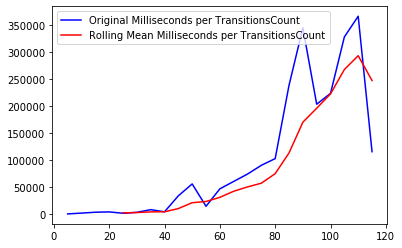

In [38]:
ms_per_places = df2.groupby('TransitionsCount').mean()['Milliseconds']
plt.plot(ms_per_places, color="blue",label="Original Milliseconds per TransitionsCount") 
rolling_mean = ms_per_places.rolling(5).mean() 
plt.plot(rolling_mean, color="red", label="Rolling Mean Milliseconds per TransitionsCount") 
plt.legend(loc="best")